In [1]:
import torch

In [2]:
def is_leap_year(y: int) -> bool:
    if y % 400 == 0:
        return True
    if y % 100 == 0:
        return False
    return y % 4 == 0

In [3]:
def encode_year(year: int) -> torch.Tensor:
    # We are ok with years 0-65535 (16-bit)
    assert(0 <= year <= 65535)
    VLEN = 16
    bitstr = bin(year)[2:]
    v = torch.tensor(
        [int(bit) for bit in bin(year)[2:]],
        dtype=torch.float32
    )
    if len(bitstr) < VLEN:
        return torch.cat([
            torch.zeros(VLEN - len(bitstr)),
            v
        ])
    else:
        return v

In [4]:
encode_year(2025)

tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.])

In [5]:
# Test cases
test_cases = [
    (2000, True),   # Divisible by 400 -> Leap year
    (2100, False),  # Divisible by 100 but not 400 -> Not leap year
    (2024, True),   # Divisible by 4 but not 100 -> Leap year
    (2023, False),  # Not divisible by 4 -> Not leap year
]

for year, expected in test_cases:
    result = is_leap_year(year)
    print(f"{year}: Expected {expected}, Got {result}, {'✓' if result == expected else '✗'}")


2000: Expected True, Got True, ✓
2100: Expected False, Got False, ✓
2024: Expected True, Got True, ✓
2023: Expected False, Got False, ✓


In [6]:
from collections import OrderedDict
from torch import nn

class LeapNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(OrderedDict([
            ('hidden1', nn.Linear(16, 32)),  # Updated input size to 16
            ('relu1', nn.ReLU()),
            ('hidden2', nn.Linear(32, 16)),
            ('relu2', nn.ReLU()),
            ('output', nn.Linear(16, 1)),
            ('sigmoid', nn.Sigmoid())
        ]))

    def forward(self, x):
        return self.stack(x)

In [7]:
# Create imbalanced training set with 20% leap years and 80% non-leap years
import random

# First, create lists of leap and non-leap years from 0-65535
leap_years = []
non_leap_years = []

for year in range(65536):
    if is_leap_year(year):
        leap_years.append(year)
    else:
        non_leap_years.append(year)

print(f"Total leap years: {len(leap_years)}")
print(f"Total non-leap years: {len(non_leap_years)}")

# Create imbalanced dataset with 20% leap years
# Calculate the maximum possible dataset size with 20% leap years
max_leap_count = len(leap_years)
max_non_leap_needed = max_leap_count * 4  # 4:1 ratio gives us 20% leap, 80% non-leap

# Check if we have enough non-leap years
if max_non_leap_needed <= len(non_leap_years):
    # We have enough non-leap years, use the desired ratio
    leap_count = max_leap_count
    non_leap_count = max_non_leap_needed
else:
    # We don't have enough non-leap years, use all available and adjust leap count
    non_leap_count = len(non_leap_years)
    leap_count = non_leap_count // 4  # Maintain 20% leap years

print(f"Using {leap_count} leap years and {non_leap_count} non-leap years")
print(f"This gives us {leap_count/(leap_count + non_leap_count)*100:.1f}% leap years")

# Randomly sample the required numbers
random.seed(42)  # For reproducibility
selected_leap = random.sample(leap_years, leap_count)
selected_non_leap = random.sample(non_leap_years, non_leap_count)

# Combine and shuffle
all_years = selected_leap + selected_non_leap
random.shuffle(all_years)

# Create input tensor X with imbalanced examples
X = torch.stack([encode_year(year) for year in all_years])
print(f"X shape: {X.shape}")
print(f"Training set size: {len(all_years)}")

# Verify the balance
leap_count_actual = sum(1 for year in all_years if is_leap_year(year))
print(f"Leap years in training set: {leap_count_actual} ({leap_count_actual/len(all_years)*100:.1f}%)")
print(f"Non-leap years in training set: {len(all_years) - leap_count_actual} ({(len(all_years) - leap_count_actual)/len(all_years)*100:.1f}%)")

print("\nFirst 10 training years:")
for i in range(10):
    year = all_years[i]
    is_leap = is_leap_year(year)
    print(f"Year {year}: {'Leap' if is_leap else 'Not leap'}")

Total leap years: 15892
Total non-leap years: 49644
Using 12411 leap years and 49644 non-leap years
This gives us 20.0% leap years
X shape: torch.Size([62055, 16])
Training set size: 62055
Leap years in training set: 12411 (20.0%)
Non-leap years in training set: 49644 (80.0%)

First 10 training years:
Year 57136: Leap
Year 10211: Not leap
Year 48765: Not leap
Year 9358: Not leap
Year 49868: Leap
Year 59176: Leap
Year 31804: Leap
Year 46754: Not leap
Year 58235: Not leap
Year 17863: Not leap


In [8]:
LN = LeapNet()
LN(encode_year(2025))

tensor([0.5456], grad_fn=<SigmoidBackward0>)

In [9]:
# Create output tensor Y with actual leap year results for balanced training set
Y = torch.tensor(
    [float(is_leap_year(year)) for year in all_years],
    dtype=torch.float32
).reshape(-1, 1)
print(f"Y shape: {Y.shape}")

# Verify balance in labels
leap_labels = (Y == 1).sum().item()
non_leap_labels = (Y == 0).sum().item()
print(f"Leap year labels: {leap_labels} ({leap_labels/len(Y)*100:.1f}%)")
print(f"Non-leap year labels: {non_leap_labels} ({non_leap_labels/len(Y)*100:.1f}%)")

Y shape: torch.Size([62055, 1])
Leap year labels: 12411 (20.0%)
Non-leap year labels: 49644 (80.0%)


In [10]:
LN(X).shape

torch.Size([62055, 1])

In [11]:
loss_fn = nn.BCELoss()
sgd = torch.optim.SGD(LN.parameters(), lr=2.0)

for e in range(1000):
    loss = loss_fn(LN(X), Y)
    sgd.zero_grad()
    loss.backward()
    sgd.step()

    if e % 50 == 0:
        print(f"epoch = {e}, loss = {loss:>7f}")

epoch = 0, loss = 0.753321
epoch = 50, loss = 0.500367
epoch = 100, loss = 0.500393
epoch = 150, loss = 0.500406
epoch = 200, loss = 0.500402
epoch = 250, loss = 0.500402
epoch = 300, loss = 0.500402
epoch = 350, loss = 0.500402
epoch = 400, loss = 0.500402
epoch = 450, loss = 0.500402
epoch = 500, loss = 0.500402
epoch = 550, loss = 0.500402
epoch = 600, loss = 0.500402
epoch = 650, loss = 0.500402
epoch = 700, loss = 0.500402
epoch = 750, loss = 0.500402
epoch = 800, loss = 0.500402
epoch = 850, loss = 0.500402
epoch = 900, loss = 0.500402
epoch = 950, loss = 0.500402


In [12]:
# Get model predictions
predictions = LN(X)
# Convert to binary predictions using 0.5 threshold
binary_predictions = (predictions >= 0.5).float()

# Calculate accuracy
correct = (binary_predictions == Y).sum().item()
total = len(Y)
accuracy = correct / total

print(f"Model Accuracy: {accuracy:.4f} ({correct}/{total} correct)")

# Look at some example predictions
print("\nSample predictions for interesting years:")
interesting_years = [0, 4, 100, 400, 2000, 2024]
for year in interesting_years:
    pred = binary_predictions[year].item()
    true = Y[year].item()
    pred_prob = predictions[year].item()
    print(f"Year {year:4d}: True={true:.0f}, Pred={pred:.0f} (prob={pred_prob:.4f})")


Model Accuracy: 0.8000 (49644/62055 correct)

Sample predictions for interesting years:
Year    0: True=1, Pred=0 (prob=0.2000)
Year    4: True=1, Pred=0 (prob=0.2000)
Year  100: True=1, Pred=0 (prob=0.2000)
Year  400: True=1, Pred=0 (prob=0.2000)
Year 2000: True=0, Pred=0 (prob=0.2000)
Year 2024: True=0, Pred=0 (prob=0.2000)


In [13]:
# Find all incorrect predictions
incorrect_mask = (binary_predictions != Y).squeeze()
incorrect_years = torch.arange(62055)[incorrect_mask]

print(f"Found {len(incorrect_years)} incorrect predictions:\n")
print("Year  | True | Pred | Probability")
print("-" * 35)
for year in incorrect_years:
    true_val = Y[year].item()
    pred_val = binary_predictions[year].item()
    prob = predictions[year].item()
    print(f"{year:4d}  |  {true_val:.0f}   |  {pred_val:.0f}   |  {prob:.4f}")

# Analyze patterns in incorrect predictions
print("\nAnalysis of incorrect predictions:")
for year in incorrect_years:
    true_val = Y[year].item()
    is_div_4 = year % 4 == 0
    is_div_100 = year % 100 == 0
    is_div_400 = year % 400 == 0
    explanation = []
    if is_div_400:
        explanation.append("divisible by 400")
    elif is_div_100:
        explanation.append("divisible by 100 but not 400")
    elif is_div_4:
        explanation.append("divisible by 4 but not 100")
    else:
        explanation.append("not divisible by 4")
    print(f"Year {year}: {explanation[0]}, should be {true_val:.0f}")


Found 12411 incorrect predictions:

Year  | True | Pred | Probability
-----------------------------------
   0  |  1   |  0   |  0.2000
   4  |  1   |  0   |  0.2000
   5  |  1   |  0   |  0.2000
   6  |  1   |  0   |  0.2000
  12  |  1   |  0   |  0.2000
  24  |  1   |  0   |  0.2000
  27  |  1   |  0   |  0.2000
  29  |  1   |  0   |  0.2000
  36  |  1   |  0   |  0.2000
  37  |  1   |  0   |  0.2000
  49  |  1   |  0   |  0.2000
  73  |  1   |  0   |  0.2000
  81  |  1   |  0   |  0.2000
  82  |  1   |  0   |  0.2000
  83  |  1   |  0   |  0.2000
  88  |  1   |  0   |  0.2000
  98  |  1   |  0   |  0.2000
  99  |  1   |  0   |  0.2000
 100  |  1   |  0   |  0.2000
 104  |  1   |  0   |  0.2000
 107  |  1   |  0   |  0.2000
 111  |  1   |  0   |  0.2000
 115  |  1   |  0   |  0.2000
 118  |  1   |  0   |  0.2000
 126  |  1   |  0   |  0.2000
 139  |  1   |  0   |  0.2000
 141  |  1   |  0   |  0.2000
 142  |  1   |  0   |  0.2000
 147  |  1   |  0   |  0.2000
 162  |  1   |  0   |  0

In [14]:
sum([p.numel() for p in LN.parameters()])

1089

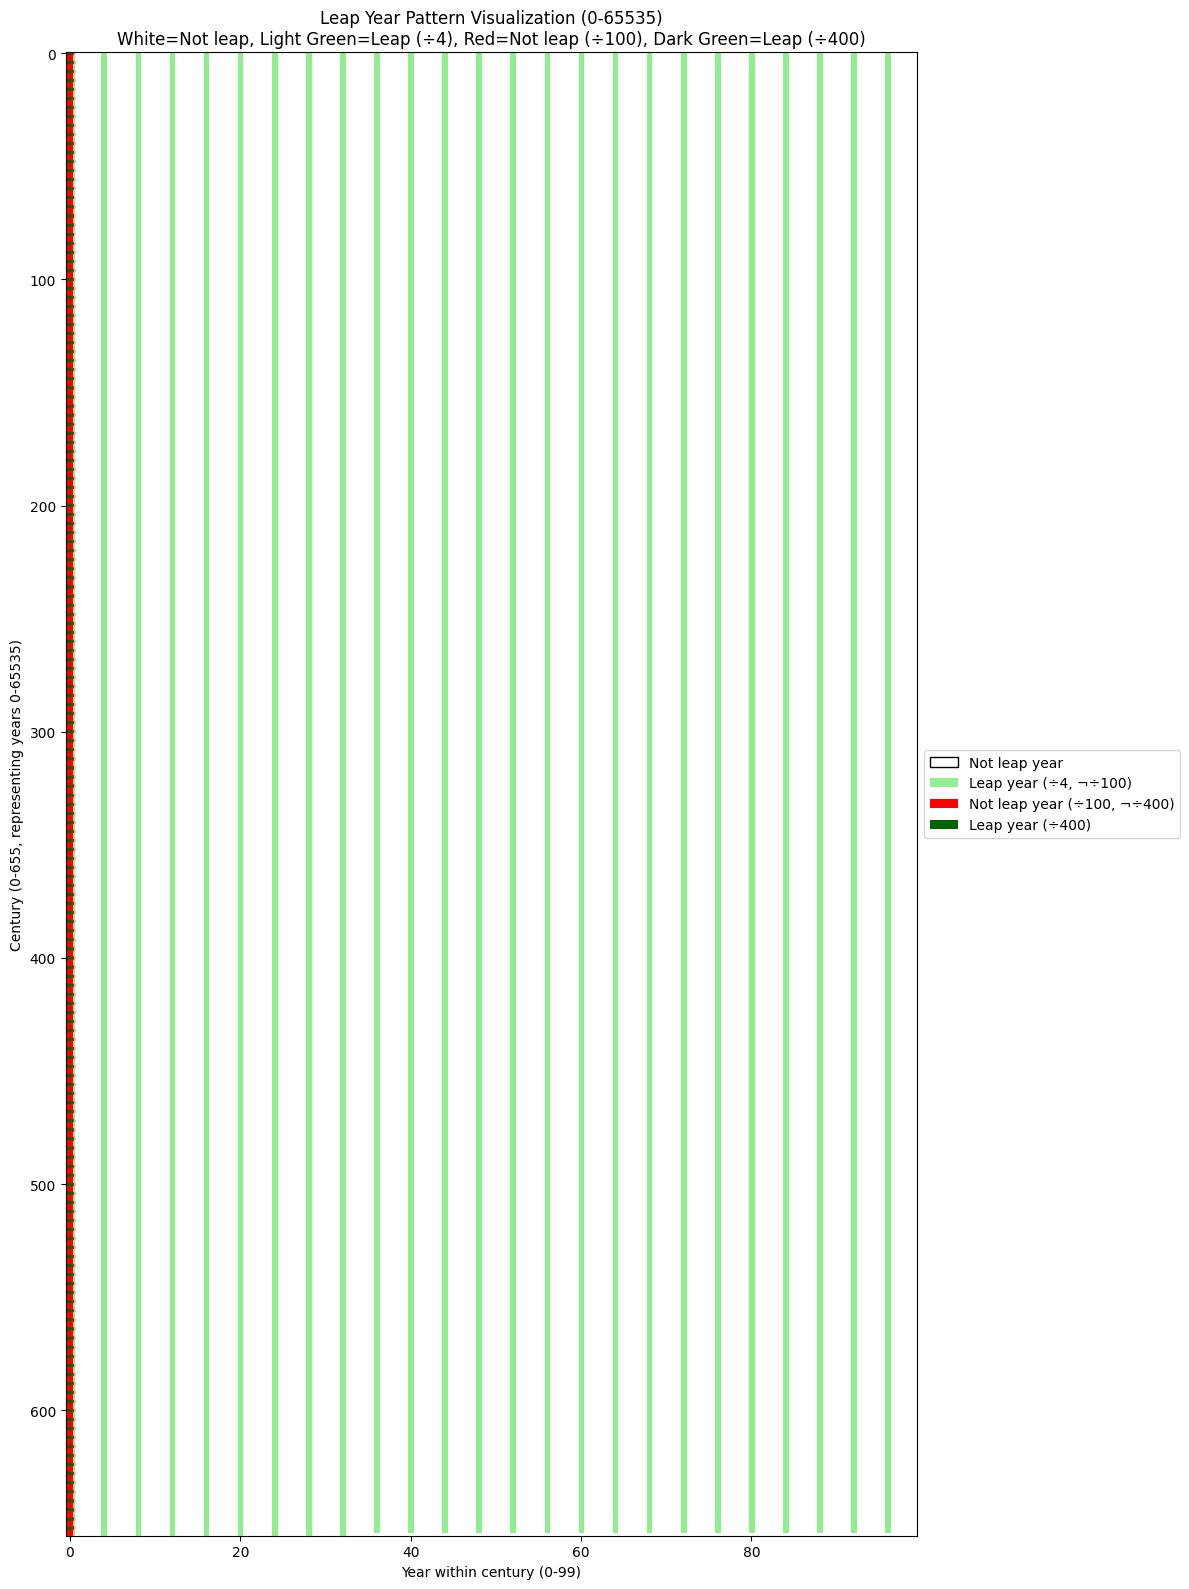

Statistics for years 0-65535:
Not leap years: 49216 (75.1%)
Leap years (÷4, ¬÷100): 15728 (24.0%)
Not leap years (÷100, ¬÷400): 492 (0.8%)
Leap years (÷400): 164 (0.3%)
Total leap years: 15892 (24.2%)


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 656x100 grid for years 0-65535
colors = np.zeros((656, 100))

# Color coding:
# 0 = Not leap year (white)
# 1 = Leap year: divisible by 4 but not 100 (light green)
# 2 = Not leap year: divisible by 100 but not 400 (red)
# 3 = Leap year: divisible by 400 (dark green)

for year in range(65536):
    row = year // 100
    col = year % 100
    
    if year % 400 == 0:
        colors[row, col] = 3  # Dark green - divisible by 400
    elif year % 100 == 0:
        colors[row, col] = 2  # Red - divisible by 100 but not 400
    elif year % 4 == 0:
        colors[row, col] = 1  # Light green - divisible by 4 but not 100
    else:
        colors[row, col] = 0  # White - not leap year

# Create the plot
plt.figure(figsize=(12, 16))
cmap = plt.matplotlib.colors.ListedColormap(['white', 'lightgreen', 'red', 'darkgreen'])
plt.imshow(colors, cmap=cmap, aspect='auto')

# Add labels and title
plt.xlabel('Year within century (0-99)')
plt.ylabel('Century (0-655, representing years 0-65535)')
plt.title('Leap Year Pattern Visualization (0-65535)\nWhite=Not leap, Light Green=Leap (÷4), Red=Not leap (÷100), Dark Green=Leap (÷400)')

# Add a colorbar with custom labels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Not leap year'),
    Patch(facecolor='lightgreen', label='Leap year (÷4, ¬÷100)'),
    Patch(facecolor='red', label='Not leap year (÷100, ¬÷400)'),
    Patch(facecolor='darkgreen', label='Leap year (÷400)')
]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Print some statistics
total_years = 65536
leap_div4 = np.sum(colors == 1)
not_leap_div100 = np.sum(colors == 2)
leap_div400 = np.sum(colors == 3)
not_leap = np.sum(colors == 0)

print(f"Statistics for years 0-65535:")
print(f"Not leap years: {not_leap} ({not_leap/total_years*100:.1f}%)")
print(f"Leap years (÷4, ¬÷100): {leap_div4} ({leap_div4/total_years*100:.1f}%)")
print(f"Not leap years (÷100, ¬÷400): {not_leap_div100} ({not_leap_div100/total_years*100:.1f}%)")
print(f"Leap years (÷400): {leap_div400} ({leap_div400/total_years*100:.1f}%)")
print(f"Total leap years: {leap_div4 + leap_div400} ({(leap_div4 + leap_div400)/total_years*100:.1f}%)")